In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from MiniDeepTaxonNet import CobwebNN, CobwebNNTreeLayer, TestModel
import argparse
import os
import sys

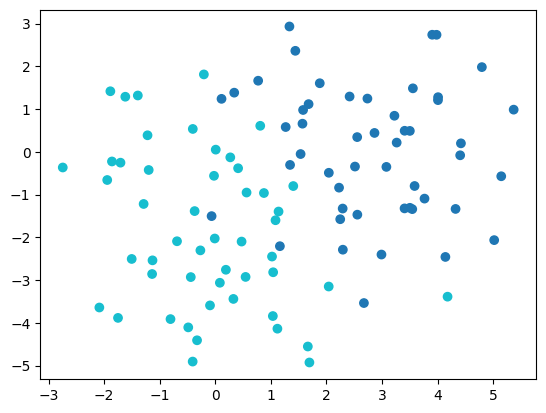

In [3]:
# create a toy daatset
# params:
# n_classes: number of classes
# n_samples: number of samples per class
# n_features: number of features

def create_toy_dataset(n_classes, n_samples, n_features):
    # for each class, random sample n_samples samples from normal distribution with random mean and variance
    X = np.zeros((n_classes * n_samples, n_features))
    for i in range(n_classes):
        mean = np.random.rand(n_features)
        cov = np.eye(n_features) * np.random.rand(n_features)
        X[i * n_samples:(i + 1) * n_samples] = np.random.multivariate_normal(mean, cov, n_samples)

    # normalize the data between 0 and 1
    X = (X - X.min()) / (X.max() - X.min())

    # for each class, assign a unique label
    y = np.repeat(np.arange(n_classes), n_samples)
    return X, y

# test
X, y = create_toy_dataset(2, 50, 32)
# plot the toy dataset
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10')
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10')
plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_layers = 1
n_hidden = 8
input_dim = 32
tau = 0.1
commitment_weight = 0.25
sampling = False
kl_weight = 10
DTN = CobwebNN(input_dim=input_dim, n_layers=n_layers, n_hidden=n_hidden,
                  disable_decoder_sigmoid=False, tau=tau, 
                  layer_wise=False, sampling=sampling, simple_encoder=True
                  ).to(device)

optimizer = optim.Adam(DTN.parameters(), lr=1e-3)

dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
def viz():   # pass the train data and plot the latent representation
    all_latent = []
    all_labels = []
    all_nodes = []

    with torch.no_grad():
        for j, (data, target) in enumerate(train_loader):
            data = data.to(device)
            x, means, logvars, x_preds, p_x_nodes, p_node_xs, x_latent, x_sampled = DTN(data)
            all_latent.append(x_latent.cpu().detach().numpy())
            all_labels.append(target.cpu().detach().numpy())
        # all_nodes.append(means)
    all_nodes = torch.cat(means, dim=0)

    all_latent = np.concatenate(all_latent, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_nodes = all_nodes.cpu().detach().numpy()
    # print(all_nodes.shape)
    # print(all_latent.shape)

    # append all_nodes to all_latent
    all_latent = np.concatenate([all_latent, all_nodes], axis=0)
    # extend all_labels
    all_labels = np.concatenate([all_labels, np.repeat(2, all_nodes.shape[0])], axis=0)
    # plt.scatter(all_latent[:, 0], all_latent[:, 1], c=all_labels, cmap='tab10')
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(all_latent)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=all_labels, cmap='tab10')
    # plt.show()
    plt.savefig('viz_out/latent.png')
    plt.close()

Epoch 0
Epoch 50
Epoch 100
Epoch 150
Epoch 200
Epoch 250
Epoch 300
Epoch 350
Epoch 400
Epoch 450
Epoch 500


KeyboardInterrupt: 

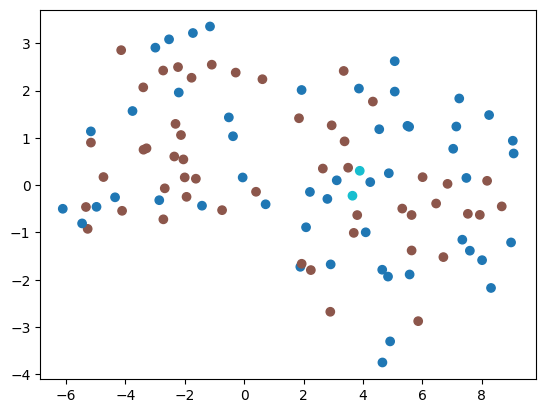

In [10]:
steps = 0
# create a dataloader form X and y
total_loss = []

epochs = 2000
for epoch in range(epochs):
    if epoch % 50 == 0:
        print(f'Epoch {epoch}')
    if epoch % 2 == 0:
        viz()
    for j, (data, target) in enumerate(train_loader):
        # cobweb.train()
        optimizer.zero_grad()

        data = data.to(device)
        x, means, logvars, x_preds, p_x_nodes, p_node_xs, x_latent, _ = DTN(data)
        loss = 0
        PTY = 0
        CMT = 0
        REC = 0
        KL = 0
        # break
        H = 0
        ########### tree-wise loss ############

            # means: 2**n_layers-1, n_hidden
            # logvars: 2**n_layers-1, n_hidden
            # x_preds: B, 512, 1, 1
            # p_node_xs: B, 2**n_layers-1
            # reconstruction loss
        REC = F.mse_loss(x_preds, data)
        # prototype loss
        # PTY = ((x_latent.detach().unsqueeze(1) - torch.cat(means, dim=0).unsqueeze(0)).pow(2).mean(dim=-1) * p_node_xs).sum(dim=-1).mean()
        # commitment loss
        # CMT = ((x_latent.unsqueeze(1) - torch.cat(means, dim=0).detach().unsqueeze(0)).pow(2).mean(dim=-1) * p_node_xs).sum(dim=-1).mean()
        if False:
            # maximize the logprob of x_latent given the means and logvars
            #  dist = -0.5 * torch.sum(logvars_cat + ((x_mu.unsqueeze(1) - means_cat.unsqueeze(0)) ** 2) / torch.exp(logvars_cat), dim=-1)
            CMT += 0.5 * torch.sum(torch.cat(logvars, dim=0) + 1e-6 + ((x_latent.unsqueeze(1) - torch.cat(means, dim=0).unsqueeze(0)) ** 2) / torch.exp(torch.cat(logvars, dim=0) + 1e-6), dim=-1).mean()
        else:
            CMT += ((x_latent.unsqueeze(1) - torch.cat(means, dim=0).unsqueeze(0)).pow(2).mean(dim=-1) * p_node_xs).sum(dim=-1).mean()
        KL = untils.cross_entropy_regularization(p_node_xs, depth=n_layers + 1, lambda_=kl_weight, entire_tree=True)
        # print(f"KL: {KL}")
        loss = REC + commitment_weight * CMT# + KL
            # print(p_node_xs.shape)
            # print(torch.cat(means, dim=0).shape

        loss.backward()
        optimizer.step()
        steps += 1
        total_loss.append(loss.item())

plt.plot(total_loss)